# Text Classification//Tensorflow

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

seed_ = 20200218
np.random.seed(seed_)
tf.random.set_seed(seed_)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid",
              context="paper",
              font_scale=1.25,
              rc={
                  "figure.figsize": (10.5, 4.5),
                  "figure.dpi": 150,
                  "grid.alpha": 0.1,
                  "grid.color": "#1b262c",
                  "grid.linewidth": 0.5,
                  "font.family": "Operator Mono",
              })
# original first color is #202f66
_30k = ["#3a5b91", "#ff7048", "#7f68d0", "#f3d36e", "#d869ab", "#48ADA9", "#1b262c"]
sns.set_palette(_30k)

import warnings
warnings.filterwarnings('ignore')

In [3]:
import re
import string

import nltk
from nltk.corpus import stopwords
import wordcloud

import gensim
from gensim.models import Word2Vec

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
from sklearn.metrics import classification_report

In [6]:
stop_words = stopwords.words("english")

# Load Data

In [7]:
train_df = pd.read_csv("./cleaned/train.csv")
test_df = pd.read_csv("./cleaned/test.csv")

In [8]:
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Sentiment_new,cleaned_text
0,3799,48751,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,neutral,and and
1,3800,48752,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive,positive,advice Talk to your neighbours family to excha...
2,3801,48753,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive,positive,Coronavirus Australia: Woolworths to give elde...
3,3802,48754,NaN,2020-03-16,My food stock is not the only one which is emp...,Positive,positive,My food stock is not the only one which is emp...
4,3803,48755,NaN,2020-03-16,"Me, ready to go at supermarket during the #COV...",Extremely Negative,negative,"Me, ready to go at supermarket during the out..."


In [9]:
test_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Sentiment_new,cleaned_text
0,1,44953,NYC,2020-02-03,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,negative,TRENDING: New Yorkers encounter empty supermar...
1,2,44954,"Seattle, WA",2020-02-03,When I couldn't find hand sanitizer at Fred Me...,Positive,positive,When I couldn't find hand sanitizer at Fred Me...
2,3,44955,NaN,2020-02-03,Find out how you can protect yourself and love...,Extremely Positive,positive,Find out how you can protect yourself and love...
3,4,44956,Chicagoland,2020-02-03,#Panic buying hits #NewYork City as anxious sh...,Negative,negative,buying hits City as anxious shoppers stock u...
4,5,44957,"Melbourne, Victoria",2020-03-03,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,neutral,One week everyone buying baby m...


# Preprocess Text

In [10]:
train_df['cleaned_text'] = train_df['cleaned_text'].apply(str)
test_df['cleaned_text'] = test_df['cleaned_text'].apply(str)

In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['cleaned_text'])

In [12]:
vocab_size = len(tokenizer.word_index)+1
vocab_size

39986

In [13]:
x_train = tokenizer.texts_to_sequences(train_df['cleaned_text'])
x_test = tokenizer.texts_to_sequences(test_df['cleaned_text'])

In [14]:
max_length = np.max([len(i) for i in x_train])
max_length

64

In [15]:
x_train = pad_sequences(x_train, maxlen=max_length, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=max_length, padding='post', truncating='post')

# preprocess output

In [16]:
train_df['Sentiment_new'].drop_duplicates()

0     neutral
1    positive
4    negative
Name: Sentiment_new, dtype: object

In [17]:
test_df['Sentiment_new'].drop_duplicates()

0    negative
1    positive
4     neutral
Name: Sentiment_new, dtype: object

In [18]:
sentiment = {'negative': 2, 'positive': 1, 'neutral': 0}

In [19]:
y_train = np.array(train_df['Sentiment_new'].map(sentiment))
y_test = np.array(test_df['Sentiment_new'].map(sentiment))

# Summary preprocessed

In [20]:
x_train.shape, x_test.shape

((41157, 64), (3798, 64))

In [21]:
y_train.shape, y_test.shape

((41157,), (3798,))

In [22]:
vocab_size

39986

In [23]:
max_length

64

# Model

In [24]:
embedding_dims = 16

In [25]:
model = tf.keras.Sequential()

model.add(
    tf.keras.layers.Embedding(input_dim=vocab_size, 
                              output_dim=embedding_dims, 
                              input_length=max_length)
)

model.add(
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation='relu', return_sequences=True))
)
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.GlobalAvgPool1D())
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 64, 16)            639776    
_________________________________________________________________
bidirectional (Bidirectional (None, 64, 64)            12544     
_________________________________________________________________
dropout (Dropout)            (None, 64, 64)            0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 51        
Total params: 653,411
Trainable params: 653,411
Non-trainable params: 0
__________________________________________________

In [27]:
optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [28]:
num_epochs = 15

hist = model.fit(x_train, y_train, epochs=num_epochs, batch_size=256, validation_data=(x_test, y_test))

Epoch 1/15
161/161 [==============================] - 38s 234ms/step - loss: 1.0109 - accuracy: 0.4471 - val_loss: 0.9547 - val_accuracy: 0.4466
Epoch 2/15
161/161 [==============================] - 37s 228ms/step - loss: 0.9148 - accuracy: 0.5107 - val_loss: 0.8641 - val_accuracy: 0.4955
Epoch 3/15
161/161 [==============================] - 38s 234ms/step - loss: 0.8401 - accuracy: 0.5967 - val_loss: 0.8319 - val_accuracy: 0.6172
Epoch 4/15
161/161 [==============================] - 36s 225ms/step - loss: 0.6849 - accuracy: 0.7252 - val_loss: 0.7186 - val_accuracy: 0.6809
Epoch 5/15
161/161 [==============================] - 36s 225ms/step - loss: 0.4867 - accuracy: 0.8282 - val_loss: 0.6289 - val_accuracy: 0.7520
Epoch 6/15
161/161 [==============================] - 37s 231ms/step - loss: 0.3605 - accuracy: 0.8788 - val_loss: 0.6350 - val_accuracy: 0.7646
Epoch 7/15
161/161 [==============================] - 38s 233ms/step - loss: 0.2793 - accuracy: 0.9143 - val_loss: 0.6311 - val_ac

In [29]:
model.save("./outputs/covid-model.h5", save_format='h5')

## Plot loss

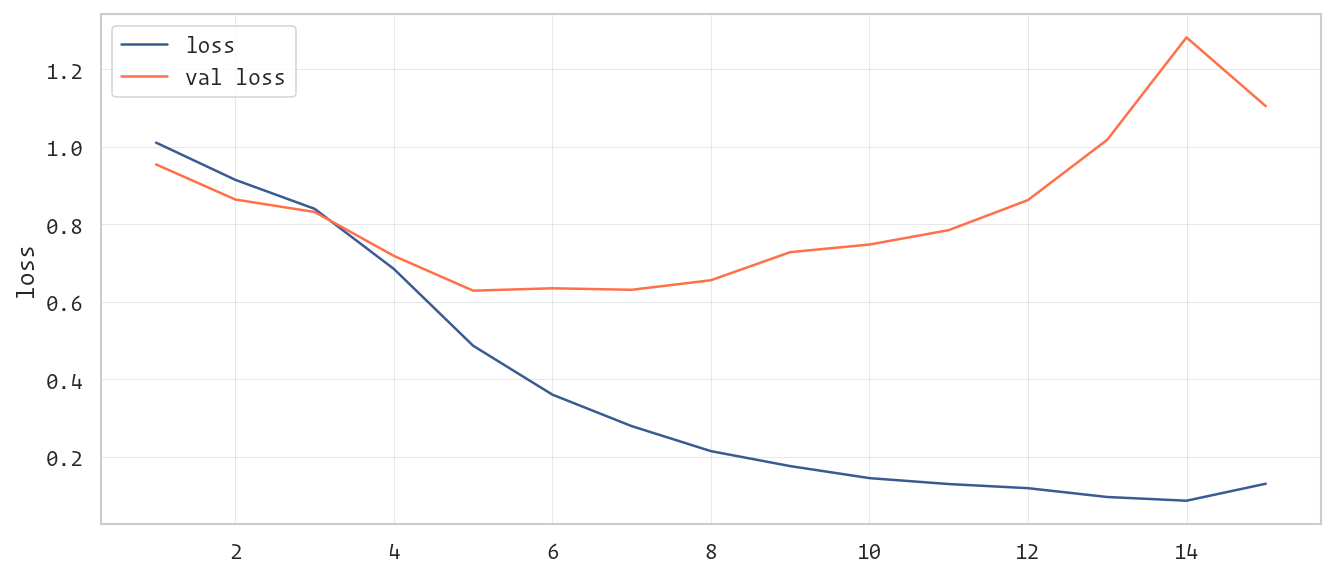

In [30]:
epochs = np.arange(1, num_epochs+1)

sns.lineplot(epochs, hist.history['loss'], label='loss')
sns.lineplot(epochs, hist.history['val_loss'], label='val loss')
plt.ylabel('loss')
plt.show()

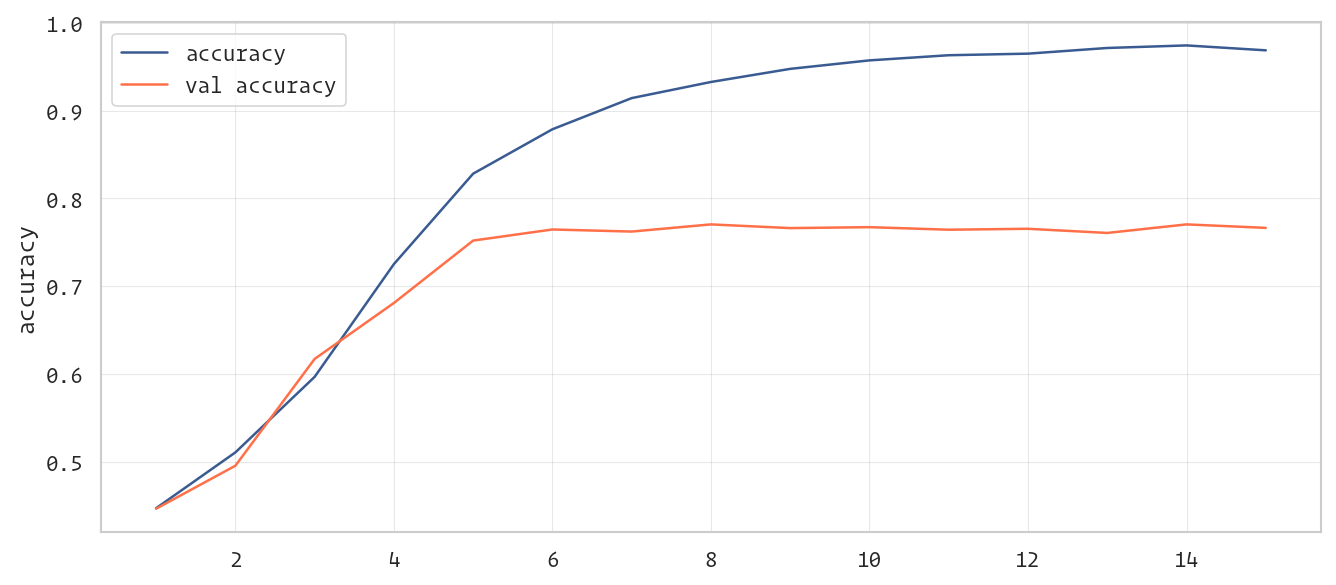

In [31]:
epochs = np.arange(1, num_epochs+1)

sns.lineplot(epochs, hist.history['accuracy'], label='accuracy')
sns.lineplot(epochs, hist.history['val_accuracy'], label='val accuracy')
plt.ylabel('accuracy')
plt.show()

## Confusion Matrix

In [32]:
pred_trian = model.predict_classes(x_train)
pred_test = model.predict_classes(x_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [33]:
cm = tf.math.confusion_matrix(y_train, pred_trian)

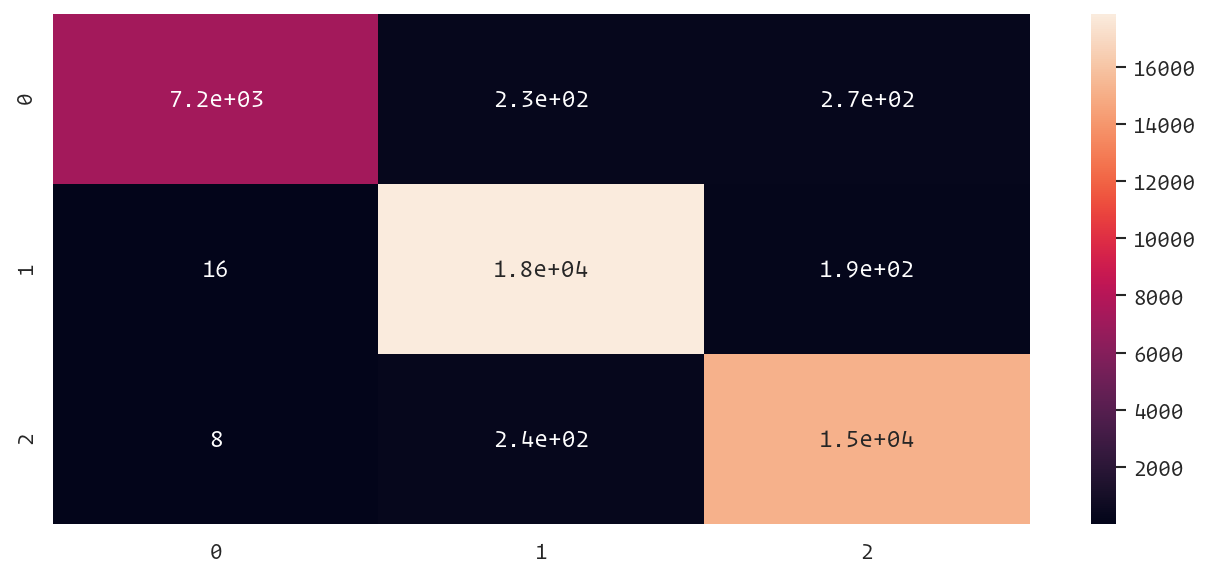

In [34]:
sns.heatmap(cm, annot=True)
plt.show()

In [35]:
print(classification_report(y_train, pred_trian))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96      7713
           1       0.97      0.99      0.98     18046
           2       0.97      0.98      0.98     15398

    accuracy                           0.98     41157
   macro avg       0.98      0.97      0.97     41157
weighted avg       0.98      0.98      0.98     41157



In [36]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.81      0.60      0.69       619
           1       0.74      0.82      0.78      1546
           2       0.78      0.78      0.78      1633

    accuracy                           0.77      3798
   macro avg       0.78      0.73      0.75      3798
weighted avg       0.77      0.77      0.76      3798

